# Finding Elo Kaggle Competition
### Predict a chess player's FIDE Elo rating from one game

Our imports and constant values

In [148]:
import math
import numpy as np # linear algebra
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import chess.pgn


GAME_DATA_FILE = "data_short.pgn"
MOVE_EVAL_FILE = "stockfish_short.csv"

game_moves_scores_df = pd.read_csv(MOVE_EVAL_FILE)

REGULAR_LENGTH = 25000
SHORT_LENGTH = 15

TRAINING_SET_LENGTH = SHORT_LENGTH
TEST_SET_LENGTH = SHORT_LENGTH

Totaling the sum of move scores of each game and adding it to a list

In [149]:
def calculate_win(centipawns):
    winning_chances = 2 / (1 + math.exp(-0.00368208 * centipawns)) - 1
    win_percentage = 50 + 50 * (winning_chances)
    return win_percentage

def calculate_accuracy(winPercentBefore, winPercentAfter):
    if winPercentAfter >= winPercentBefore:
        return 100
    else:
        win_diff = winPercentBefore - winPercentAfter
        accuracy_percentage =  103.1668100711649 * math.exp(-0.04354415386753951 * win_diff) - 3.166924740191411
        accuracy_percentage += 1
        return max(min(accuracy_percentage, 100), 0)

def get_move_analysis_list(moves_list):
    scores = []
    deltas = []
    win_percentages = []
    accuracy_percentages = []
    for i in range(len(moves_list)):
        # raw score
        score = int(moves_list[i])
        scores.append(score)

        # raw score delta
        if i < len(moves_list) - 1:
            next_score = int(moves_list[i+1])
            delta = next_score - score
            deltas.append(delta)

        # win percentage each move
        win_percentage = calculate_win(score)
        win_percentages.append(win_percentage)

        # accuracy percentage each move
        if i > 0:
            accuracy_percentage = calculate_accuracy(win_percentages[i - 1], win_percentage)
            accuracy_percentages.append(accuracy_percentage)
        
    return scores, deltas, win_percentages, accuracy_percentages

def get_features_stats(scores, deltas, win_percentages, accuracy_percentages):
    stats_list = []

    scores = np.array(scores)
    sum = np.sum(scores)
    min = np.min(scores)
    max = np.max(scores)
    mean = np.mean(scores)
    median = np.median(scores)
    stdev = np.std(scores)
    new_stats = [sum, min, max, mean, median, stdev]
    stats_list.extend(new_stats)

    deltas = np.array(deltas)
    sum = np.sum(deltas)
    min = np.min(deltas)
    max = np.max(deltas)
    mean = np.mean(deltas)
    median = np.median(deltas)
    stdev = np.std(deltas)
    new_stats = [sum, min, max, mean, median, stdev]
    stats_list.extend(new_stats)

    win_percentages = np.array(win_percentages)
    sum = np.sum(win_percentages)
    min = np.min(win_percentages)
    max = np.max(win_percentages)
    mean = np.mean(win_percentages)
    median = np.median(win_percentages)
    stdev = np.std(win_percentages)
    new_stats = [sum, min, max, mean, median, stdev]
    stats_list.extend(new_stats)

    accuracy_percentages = np.array(accuracy_percentages)
    sum = np.sum(accuracy_percentages)
    min = np.min(accuracy_percentages)
    max = np.max(accuracy_percentages)
    mean = np.mean(accuracy_percentages)
    median = np.median(accuracy_percentages)
    stdev = np.std(accuracy_percentages)
    new_stats = [sum, min, max, mean, median, stdev]
    stats_list.extend(new_stats)

    return stats_list


white_moves_stats = []
black_moves_stats = []
for i in game_moves_scores_df.index:
    move_scores_str = game_moves_scores_df['MoveScores'][i]
    # print(f"{move_scores_str}")

    game_scores = move_scores_str.split()
    white_moves = game_scores[::2]
    black_moves = game_scores[1::2]

    white_scores, white_deltas, white_win_percentages, white_accuracy_percentages = get_move_analysis_list(white_moves)
    black_scores, black_deltas, black_win_percentages, black_accuracy_percentages = get_move_analysis_list(black_moves)

    white_total_moves = len(white_scores)
    white_stats = get_features_stats(white_scores, white_deltas, white_win_percentages, white_accuracy_percentages)

    white_stats.insert(0, white_total_moves)
    white_moves_stats.append(white_stats)

    black_total_moves = len(black_scores)
    black_stats = get_features_stats(black_scores, black_deltas, black_win_percentages, black_accuracy_percentages)

    black_stats.insert(0, black_total_moves)
    black_moves_stats.append(black_stats)

white_moves_stats = np.array(white_moves_stats)
white_moves_stats = pd.DataFrame(white_moves_stats, columns=['w_move_count', 'w_scores_sum', 'w_scores_min', 'w_scores_max', 'w_scores_mean', 'w_scores_median', 'w_scores_std',
                                                             'w_deltas_sum', 'w_deltas_min', 'w_deltas_max', 'w_deltas_mean', 'w_deltas_median', 'w_deltas_std',
                                                             'w_win_percentages_sum', 'w_win_percentages_min', 'w_win_percentages_max', 'w_win_percentages_mean', 'w_win_percentages_median', 'w_win_percentages_std',
                                                             'w_accuracy_percentages_sum', 'w_accuracy_percentages_min', 'w_accuracy_percentages_max', 'w_accuracy_percentages_mean', 'w_accuracy_percentages_median', 'w_accuracy_percentages_std'])
print(white_moves_stats.head())

black_moves_stats = np.array(black_moves_stats)
black_moves_stats = pd.DataFrame(black_moves_stats, columns=['b_move_count', 'b_scores_sum', 'b_scores_min', 'b_scores_max', 'b_scores_mean', 'b_scores_median', 'b_scores_std',
                                                             'b_deltas_sum', 'b_deltas_min', 'b_deltas_max', 'b_deltas_mean', 'b_deltas_median', 'b_deltas_std',
                                                             'b_win_percentages_sum', 'b_win_percentages_min', 'b_win_percentages_max', 'b_win_percentages_mean', 'b_win_percentages_median', 'b_win_percentages_std',
                                                             'b_accuracy_percentages_sum', 'b_accuracy_percentages_min', 'b_accuracy_percentages_max', 'b_accuracy_percentages_mean', 'b_accuracy_percentages_median', 'b_accuracy_percentages_std'])
print(black_moves_stats.head())

   w_move_count  w_scores_sum  w_scores_min  w_scores_max  w_scores_mean  \
0          19.0         394.0         -26.0          70.0      20.736842   
1           7.0         236.0          14.0          55.0      33.714286   
2          53.0      -38229.0      -10866.0          69.0    -721.301887   
3          39.0        1694.0         -27.0         198.0      43.435897   
4          25.0        7338.0          10.0         875.0     293.520000   

   w_scores_median  w_scores_std  w_deltas_sum  w_deltas_min  w_deltas_max  \
0             18.0     26.582230          17.0         -35.0          74.0   
1             36.0     12.220759          29.0         -12.0          22.0   
2            -49.0   2296.739359      -10892.0       -4569.0          49.0   
3             34.0     55.916969         194.0         -54.0          64.0   
4            140.0    308.072994         849.0         -25.0         294.0   

   ...  w_win_percentages_max  w_win_percentages_mean  \
0  ...           

Reading each chess game and getting the stats from it

In [150]:
chess_games = open(GAME_DATA_FILE)

training_games_data = []
for i in range(TRAINING_SET_LENGTH):
    print(f"Parsing game #{i+1} of {TRAINING_SET_LENGTH}", end="\r")
    game = chess.pgn.read_game(chess_games)

    game_number = int(game.headers["Event"])
    white_elo = int(game.headers['WhiteElo'])
    black_elo = int(game.headers['BlackElo'])
    result = game.headers['Result']
    training_games_data.append([game_number, white_elo, black_elo, result])

# print("\n")
# test_games_data = []
# for i in range(TEST_SET_LENGTH):
#     print(f"Parsing game #{i+1} of {TEST_SET_LENGTH}", end="\r")
#     game = chess.pgn.read_game(chess_games)

#     game_number = int(game.headers["Event"])
#     result = game.headers['Result']
#     test_games_data.append([game_number, result])

Turning the game stats list into a Pandas Dataframe

In [151]:
# print(training_games_data[:10])
training_data_np = np.array(training_games_data, dtype=object)
# print(training_data_np)

# test_data_np = np.array(test_games_data, dtype=object)
# print(test_data_np)

training_data = pd.DataFrame(training_data_np, columns=['event_id', 'w_elo', 'b_elo', 'result'])
# test_data = pd.DataFrame(test_data_np, columns=['Event ID', 'Result'])
print(training_data.head())
# print(test_data.head())

  event_id w_elo b_elo   result
0        1  2354  2411  1/2-1/2
1        2  2523  2460  1/2-1/2
2        3  1915  1999      0-1
3        4  2446  2191      1-0
4        5  2168  2075      1-0


One hot encoding the 'Result' column and finalizing all of the fields in our final training data set

In [153]:
training_data_one_hot = pd.get_dummies(training_data['result']).astype(int)
training_data_one_hot.rename(columns={'0-1': 'b_won', '1-0': 'w_won', '1/2-1/2': 'draw'}, inplace=True)
# print(training_data_one_hot)

# print(training_data.head())
training_data_new = training_data.drop("result", axis=1)
# print(training_data_new.head())
training_data_new_new = pd.concat([training_data_new, training_data_one_hot], axis=1)
print(training_data_new_new.head())
training_data = training_data_new_new


  event_id w_elo b_elo  b_won  w_won  draw
0        1  2354  2411      0      0     1
1        2  2523  2460      0      0     1
2        3  1915  1999      1      0     0
3        4  2446  2191      0      1     0
4        5  2168  2075      0      1     0


Adding moves stats to the training dataset

In [154]:
training_data_with_w_stats = pd.concat([training_data, white_moves_stats], axis=1)
# print(training_data_with_w_stats.head())

training_data_with_b_stats = pd.concat([training_data_with_w_stats, black_moves_stats], axis=1)
# print(training_data_with_b_stats.head())

training_data = training_data_with_b_stats
print(training_data.head())

  event_id w_elo b_elo  b_won  w_won  draw  w_move_count  w_scores_sum  \
0        1  2354  2411      0      0     1          19.0         394.0   
1        2  2523  2460      0      0     1           7.0         236.0   
2        3  1915  1999      1      0     0          53.0      -38229.0   
3        4  2446  2191      0      1     0          39.0        1694.0   
4        5  2168  2075      0      1     0          25.0        7338.0   

   w_scores_min  w_scores_max  ...  b_win_percentages_max  \
0         -26.0          70.0  ...              56.679628   
1          14.0          55.0  ...              54.772134   
2      -10866.0          69.0  ...              58.478151   
3         -27.0         198.0  ...              66.153418   
4          10.0         875.0  ...              96.696093   

   b_win_percentages_mean  b_win_percentages_median  b_win_percentages_std  \
0               52.491467                 51.656330               2.371369   
1               53.277248       

Getting the training features and labels and splitting it into training and validation sets

In [ ]:
training_features = training_data[["Black Won", "White Won", "Draw"]]
training_labels = training_data["White Elo"]
print(training_features)
print(training_labels)

x_train, x_validation, y_train, y_validation = train_test_split(training_features, training_labels, train_size=0.8, test_size=0.2, random_state=6)
print(x_train.shape)
print(x_validation.shape)
 
print(y_train.shape)
print(y_validation.shape)


       White Game Score  Black Won  White Won  Draw
0             -0.056505          0          0     1
1             -0.074755          0          0     1
2             -3.003488          1          0     0
3              0.057830          0          1     0
4              0.502320          0          1     0
...                 ...        ...        ...   ...
24995         -0.109944          1          0     0
24996         -0.410105          1          0     0
24997          0.210371          0          1     0
24998          0.307211          0          1     0
24999         -0.387928          1          0     0

[25000 rows x 4 columns]
0        2354
1        2523
2        1915
3        2446
4        2168
         ... 
24995    1844
24996    2391
24997    2634
24998    2319
24999    1717
Name: White Elo, Length: 25000, dtype: object
(20000, 4)
(5000, 4)
(20000,)
(5000,)


Graphing the relationship between a game's score and white's elo rating

0       -0.056505
1       -0.074755
2       -3.003488
3        0.057830
4        0.502320
           ...   
24995   -0.109944
24996   -0.410105
24997    0.210371
24998    0.307211
24999   -0.387928
Name: White Game Score, Length: 25000, dtype: float64


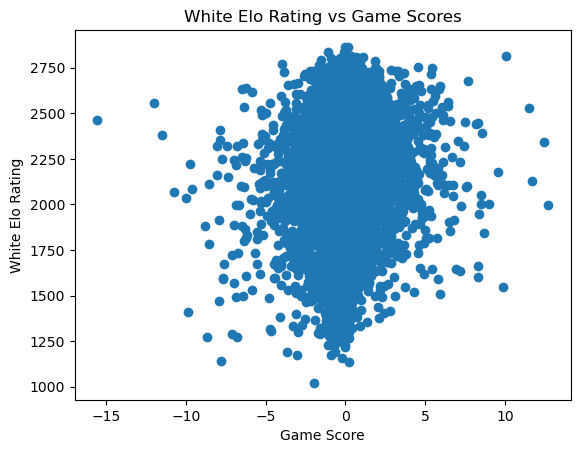

In [ ]:
temp = game_scores_sums_np.flatten()
training_game_scores_sums_series = pd.Series(temp[:TRAINING_SET_LENGTH])
print(standardized_scores)

# print(type(training_labels))



plt.scatter(standardized_scores, training_labels)
plt.xlabel("Game Score")
plt.ylabel("White Elo Rating")
plt.title("White Elo Rating vs Game Scores")
plt.show()

Building and training the model and then predicting

In [ ]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(x_train, y_train)

y_predicted = linear_regression_model.predict(x_validation)

print("Training score:")
print(linear_regression_model.score(x_train, y_train))

print("Test score:")
print(linear_regression_model.score(x_validation, y_validation))

print("Coefficients:")
print(linear_regression_model.coef_)

Training score:
0.07978168610517944
Test score:
0.06589662503897553
Coefficients:
[  -6.42909708 -114.39389577   62.01354597   52.3803498 ]


Visualizing the results of the model using a scatter plot

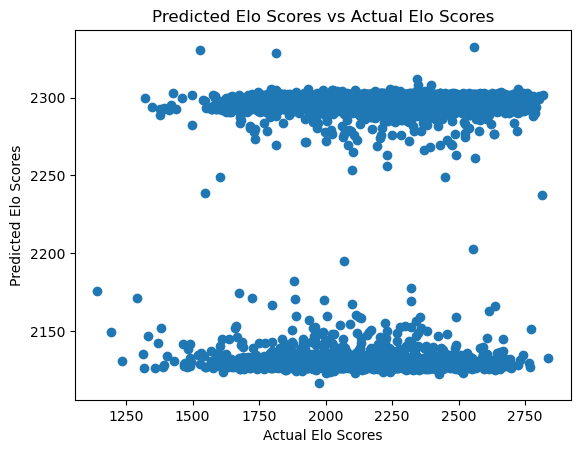

In [ ]:
plt.scatter(y_validation, y_predicted)
plt.xlabel("Actual Elo Scores")
plt.ylabel("Predicted Elo Scores")
plt.title("Predicted Elo Scores vs Actual Elo Scores")
plt.show()